<a href="https://colab.research.google.com/github/javis216/ExData_Plotting1/blob/master/Ejercicio_Predicci%C3%B3n_precio_Acci%C3%B3n_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from datetime import date,datetime
from dateutil.relativedelta import relativedelta as rd

from functools import reduce
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

from varclushi import VarClusHi

from scipy.stats import ks_2samp

from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',2000)

%matplotlib inline

In [2]:
pip install varclushi

## Lectura de datos

## Ventanas de tiempo

In [3]:
#Semanas
vobs = 24
vdes = 24

### Muestreo

In [4]:
#Muestra 
df_sample = pd.DataFrame(pd.read_csv ('viajes_ml (1).csv'))
df_sample.shape

(1098097, 19)

In [5]:
df_sample.columns

Index(['Journey_ID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'total_amount', 'Vendor_ID', 'Payment_Type_ID',
       'Rate_Code_ID', 'Store_Forward_ID', 'Location_ID_PU', 'Borough_ID_PU',
       'hour', 'minute', 'month', 'second', 'day_by_month', 'day_by_year',
       'week'],
      dtype='object')

In [6]:
df_sample.drop(index=df_sample[df_sample['Vendor_ID']==4].index,inplace=True)
df_sample.drop(index=df_sample[df_sample['Rate_Code_ID']==99].index,inplace=True)
df_sample.drop('dropoff_datetime',axis=1,inplace = True)
df_sample['pickup_datetime'] = list(map(lambda x: pd.to_datetime(x),df_sample['pickup_datetime']))
df_sample = df_sample[(df_sample['pickup_datetime']>=datetime(2018,8,1)) & (df_sample['pickup_datetime']<datetime(2019,1,1))]
df_sample['date'] = list(map(lambda x: pd.to_datetime(x),df_sample['pickup_datetime']))

### Catálogo de fechas

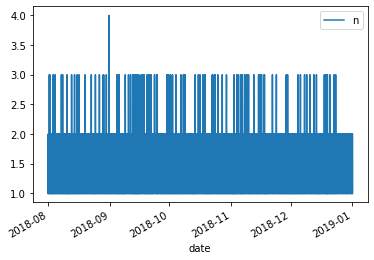

In [7]:
cat = df_sample[['date']].assign(n=1).copy()
cat.groupby('date').sum().plot()

In [8]:
cat = df_sample[['date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
#cat = cat.loc[(cat['date']>=datetime(2018,1,1)) & (cat['date']<datetime(2019,1,1))].reset_index(drop=True)
cat['dia'] = cat['date'].map(lambda x:int(x.strftime('%j%H')))
display(cat['dia'].unique().shape)
aux = cat[['dia']].drop_duplicates().sort_values(by='dia').reset_index(drop=True)
aux['idh'] = aux.index
cat = cat.merge(aux,on='dia',how='inner')
cat.head() 

(3672,)

,date,dia,idh
0,2018-08-01 00:00:03,21300,0
1,2018-08-01 00:00:06,21300,0
2,2018-08-01 00:00:39,21300,0
3,2018-08-01 00:01:53,21300,0
4,2018-08-01 00:04:22,21300,0


In [9]:
cat['date'] = cat['date'].map(lambda x:x.strftime("%Y-%m-%d"))
cat

,date,dia,idh
0,2018-08-01,21300,0
1,2018-08-01,21300,0
2,2018-08-01,21300,0
3,2018-08-01,21300,0
4,2018-08-01,21300,0
...,...,...,...
391843,2018-12-31,36523,3671
391844,2018-12-31,36523,3671
391845,2018-12-31,36523,3671
391846,2018-12-31,36523,3671


In [10]:
cat.drop_duplicates(inplace=True)
cat

,date,dia,idh
0,2018-08-01,21300,0
53,2018-08-01,21301,1
86,2018-08-01,21302,2
117,2018-08-01,21303,3
134,2018-08-01,21304,4
...,...,...,...
391261,2018-12-31,36519,3667
391401,2018-12-31,36520,3668
391536,2018-12-31,36521,3669
391662,2018-12-31,36522,3670


In [11]:

df_sample.drop('pickup_datetime',axis=1,inplace = True)
df_sample['date'] = df_sample['date'].map(lambda x:x.strftime("%Y-%m-%d"))
df_sample = df_sample.merge(cat,on='date',how='inner').drop('date',axis=1)

In [12]:
df_sample.head()

,Journey_ID,passenger_count,trip_distance,total_amount,Vendor_ID,Payment_Type_ID,Rate_Code_ID,Store_Forward_ID,Location_ID_PU,Borough_ID_PU,hour,minute,month,second,day_by_month,day_by_year,week,dia,idh
0,1,3,2.3,21.95,1,1,1,2,246,4,15,47,9,28,6,249,36,24900,864
1,1,3,2.3,21.95,1,1,1,2,246,4,15,47,9,28,6,249,36,24901,865
2,1,3,2.3,21.95,1,1,1,2,246,4,15,47,9,28,6,249,36,24902,866
3,1,3,2.3,21.95,1,1,1,2,246,4,15,47,9,28,6,249,36,24903,867
4,1,3,2.3,21.95,1,1,1,2,246,4,15,47,9,28,6,249,36,24904,868


## Ingenieria de datos (crear matriz $\mathcal{X}$ y vector $\vec{y}$)

In [13]:
vini = vobs-1
vfin = df_sample['idh'].max()-vdes
vini,vfin

(23, 3647)

In [14]:
df_sample.sample(5)

,Journey_ID,passenger_count,trip_distance,total_amount,Vendor_ID,Payment_Type_ID,Rate_Code_ID,Store_Forward_ID,Location_ID_PU,Borough_ID_PU,hour,minute,month,second,day_by_month,day_by_year,week,dia,idh
5020253,140914,1,8.50,35.56,1,1,1,2,170,4,5,12,9,6,14,257,37,25705,1061
8747293,638669,1,1.28,16.56,2,1,1,2,161,4,11,35,9,42,28,271,39,27113,1405
1026512,841575,1,1.40,10.30,1,2,1,2,238,4,9,59,12,52,3,337,49,33708,2984
7508731,328244,1,1.02,15.30,2,1,1,2,162,4,8,18,12,28,11,345,50,34519,3187
1577880,51120,1,0.63,8.16,2,1,1,2,141,4,20,47,12,9,14,348,50,34800,3240


In [15]:
df_sample.drop(columns = ['Journey_ID','day_by_year'],axis=1,inplace= True)

In [16]:
um = ['hour','idh']

In [17]:
var = ['passenger_count', 'trip_distance', 'total_amount']

In [18]:
agg = df_sample[um+var].groupby(um).agg(['min','max','mean'])
agg.columns = ['x_'+"_".join(c) for c in agg.columns]
agg.reset_index(inplace=True)
display(agg.shape)
agg.head()

(88128, 11)

,hour,idh,x_passenger_count_min,x_passenger_count_max,x_passenger_count_mean,x_trip_distance_min,x_trip_distance_max,x_trip_distance_mean,x_total_amount_min,x_total_amount_max,x_total_amount_mean
0,0,0,1,6,1.716981,0.1,11.26,3.186792,4.8,51.07,15.419245
1,0,1,1,6,1.716981,0.1,11.26,3.186792,4.8,51.07,15.419245
2,0,2,1,6,1.716981,0.1,11.26,3.186792,4.8,51.07,15.419245
3,0,3,1,6,1.716981,0.1,11.26,3.186792,4.8,51.07,15.419245
4,0,4,1,6,1.716981,0.1,11.26,3.186792,4.8,51.07,15.419245


### Matriz $\mathcal{X}$

In [19]:
anclas = list(range(vini,vfin+1))
len(anclas)

3625

In [20]:
anclas


[23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 20

In [21]:
aux = agg.loc[44].reset_index(drop=True)
aux

0      0.000000
1     44.000000
2      1.000000
3      5.000000
4      1.416667
5      0.000000
6     19.790000
7      4.559583
8      4.300000
9     71.850000
10    19.969861
Name: 44, dtype: float64

In [22]:
def predictoras(ancla):
    step = 2
    print(ancla)
    aux = agg.loc[(agg['idh']>=(ancla-vobs+1))&(agg['idh']<=ancla)].reset_index(drop=True)
    aux['idh'].replace(dict(zip(reversed(aux['idh'].unique()),range(1,vobs+1))),inplace=True)
    varx = aux.filter(like='x_').columns.tolist()
    
    aux = aux.pivot_table(index='hour',columns='idh',values=varx,aggfunc=['min','max','mean'])
    aux.columns = [f'{y}_{x}_{z}' for x,y,z in aux.columns]

    varx = sorted(set(["_".join(c.split('_')[:-1]) for c in aux.columns]))

    for k in range(step,vobs+step,step):
        for v in varx:
            vec = [f'{v}_{i+1}' for i in range(k)]
            aux[f'v_mean_{v}_{k}'] = aux[vec].mean(axis=1)
            aux[f'v_min_{v}_{k}'] = aux[vec].min(axis=1)
            aux[f'v_max_{v}_{k}'] = aux[vec].max(axis=1)
            aux[f'v_std_{v}_{k}'] = aux[vec].std(axis=1)
    aux = aux.filter(like='v_').reset_index()
    aux.insert(1,'ancla',ancla)
    return aux

In [23]:
X = pd.concat(map(predictoras,anclas[-100:]),ignore_index=False)

3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647


In [24]:
X.shape

(2400, 1298)

In [25]:
X

hour  ancla  v_mean_x_passenger_count_max_max_2  \
0      0   3548                                 6.0   
1      1   3548                                 5.0   
2      2   3548                                 2.0   
3      3   3548                                 6.0   
4      4   3548                                 5.0   
..   ...    ...                                 ...   
19    19   3647                                 6.0   
20    20   3647                                 6.0   
21    21   3647                                 5.0   
22    22   3647                                 6.0   
23    23   3647                                 6.0   

    v_min_x_passenger_count_max_max_2  v_max_x_passenger_count_max_max_2  \
0                                   6                                  6   
1                                   5                                  5   
2                                   2                                  2   
3                                   6                                  6   
4                                   5                                  5   
..                                ...                                ...   
19                                  6                                  6   
20                                  6                                  6   
21                                  5                                  5   
22                                  6                                  6   
23                                  6                                  6   

    v_std_x_passenger_count_max_max_2  v_mean_x_passenger_count_max_mean_2  \
0                                 0.0                                  6.0   
1                                 0.0                                  5.0   
2                                 0.0                                  2.0   
3                                 0.0                                  6.0   
4                                 0.0                                  5.0   
..                                ...                                  ...   
19                                0.0                                  6.0   
20                                0.0                                  6.0   
21                                0.0                                  5.0   
22                                0.0                                  6.0   
23                                0.0                                  6.0   

    v_min_x_passenger_count_max_mean_2  v_max_x_passenger_count_max_mean_2  \
0                                    6                                   6   
1                                    5                                   5   
2                                    2                                   2   
3                                    6                                   6   
4                                    5                                   5   
..                                 ...                                 ...   
19                                   6                                   6   
20                                   6                                   6   
21                                   5                                   5   
22                                   6                                   6   
23                                   6                                   6   

    v_std_x_passenger_count_max_mean_2  v_mean_x_passenger_count_max_min_2  \
0                                  0.0                                 6.0   
1                                  0.0                                 5.0   
2                                  0.0                                 2.0   
3                                  0.0                                 6.0   
4                                  0.0                                 5.0   
..                                 ...                                 ...   
19        

In [26]:
X.dropna()

hour  ancla  v_mean_x_passenger_count_max_max_2  \
0      0   3548                                 6.0   
1      1   3548                                 5.0   
2      2   3548                                 2.0   
3      3   3548                                 6.0   
4      4   3548                                 5.0   
..   ...    ...                                 ...   
19    19   3647                                 6.0   
20    20   3647                                 6.0   
21    21   3647                                 5.0   
22    22   3647                                 6.0   
23    23   3647                                 6.0   

    v_min_x_passenger_count_max_max_2  v_max_x_passenger_count_max_max_2  \
0                                   6                                  6   
1                                   5                                  5   
2                                   2                                  2   
3                                   6                                  6   
4                                   5                                  5   
..                                ...                                ...   
19                                  6                                  6   
20                                  6                                  6   
21                                  5                                  5   
22                                  6                                  6   
23                                  6                                  6   

    v_std_x_passenger_count_max_max_2  v_mean_x_passenger_count_max_mean_2  \
0                                 0.0                                  6.0   
1                                 0.0                                  5.0   
2                                 0.0                                  2.0   
3                                 0.0                                  6.0   
4                                 0.0                                  5.0   
..                                ...                                  ...   
19                                0.0                                  6.0   
20                                0.0                                  6.0   
21                                0.0                                  5.0   
22                                0.0                                  6.0   
23                                0.0                                  6.0   

    v_min_x_passenger_count_max_mean_2  v_max_x_passenger_count_max_mean_2  \
0                                    6                                   6   
1                                    5                                   5   
2                                    2                                   2   
3                                    6                                   6   
4                                    5                                   5   
..                                 ...                                 ...   
19                                   6                                   6   
20                                   6                                   6   
21                                   5                                   5   
22                                   6                                   6   
23                                   6                                   6   

    v_std_x_passenger_count_max_mean_2  v_mean_x_passenger_count_max_min_2  \
0                                  0.0                                 6.0   
1                                  0.0                                 5.0   
2                                  0.0                                 2.0   
3                                  0.0                                 6.0   
4                                  0.0                                 5.0   
..                                 ...                                 ...   
19        

### Vector $\vec{y}$

In [27]:
tgt = 'target_1w'
y = df_sample[um+['Vendor_ID']].copy()
y = y.groupby(um).count().reset_index()
y['ancla'] = y['idh']-1
y = X[['hour','ancla']].merge(y,on=['hour','ancla'],how='inner')
display(y.shape)
y.head()

(2400, 4)

,hour,ancla,idh,Vendor_ID
0,0,3548,3549,29
1,1,3548,3549,17
2,2,3548,3549,14
3,3,3548,3549,7
4,4,3548,3549,6


In [28]:
y = y.drop('idh',axis=1).rename(columns = {'Vendor_ID':'target_1h'})

In [29]:
y

,hour,ancla,target_1h
0,0,3548,29
1,1,3548,17
2,2,3548,14
3,3,3548,7
4,4,3548,6
...,...,...,...
2395,19,3647,141
2396,20,3647,136
2397,21,3647,127
2398,22,3647,108


In [30]:
um =['hour','ancla']

In [31]:
X = X.merge(y[um],on=um,how='inner')
X.shape

(2400, 1298)

In [32]:
y = y.sort_values(by = 'hour')
X = X.sort_values(by = 'hour')

## Análisis Exploratorio

### Datos Ausentes

In [33]:
varc = [v for v in X.columns if v[:2]=='v_']
len(varc)

1296

In [34]:
miss = 1-X[varc].describe().T[['count']]/len(X)
miss[['count']].describe()

,count
count,1296.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


#### Imputación

In [35]:
im = SimpleImputer(strategy='median')
im.fit(X[varc])
Xi = pd.DataFrame(im.transform(X[varc]),columns=varc)
Xi.shape,Xi.dropna().shape

((2400, 1296), (2400, 1296))

In [36]:
ks  = pd.DataFrame(map(lambda v:(v,ks_2samp(X[v],Xi[v]).statistic),varc),columns=['variable','ks'])
ks.loc[ks['ks']>0.1]

,variable,ks


### Varianza Nula

In [37]:
vt = VarianceThreshold()
vt.fit(Xi)
varc = [x for x,y in zip(varc, vt.get_support()) if y]
len(varc)

1296

### Datos Extremos

#### Método de percentil $P_1,P_{99}$

In [38]:
l_ext = Xi[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()

In [107]:
l_ext

[['v_mean_x_trip_distance_max_max_6', 4.43825, 28.29386666666657],
 ['v_mean_x_trip_distance_mean_max_6', 2.012864761904762, 6.284736842105263],
 ['v_mean_x_passenger_count_max_max_18', 2.3333333333333335, 6.0],
 ['v_min_x_total_amount_min_max_22', -6.3, 5.8],
 ['v_mean_x_trip_distance_min_max_18', 0.0, 0.6555777777777771],
 ['v_max_x_passenger_count_min_max_8', 0.0, 1.0],
 ['v_std_x_trip_distance_mean_max_22', 0.0, 1.0601614115803735],
 ['v_mean_x_total_amount_max_max_2', 18.3504, 176.16],
 ['v_mean_x_passenger_count_mean_max_4',
  1.170731707317073,
  2.1140350877192984],
 ['v_std_x_trip_distance_min_max_22', 0.0, 0.27363071743583356],
 ['v_std_x_total_amount_min_max_20', 0.0, 4.965735224092146],
 ['v_std_x_total_amount_max_max_22', 0.0, 38.6138547421534],
 ['v_std_x_passenger_count_max_max_20', 0.0, 1.6415653633362466],
 ['v_std_x_passenger_count_min_max_22', 0.0, 0.511766315719159],
 ['v_std_x_trip_distance_max_max_14', 0.0, 4.548124216634432],
 ['v_mean_x_total_amount_mean_max_6',

In [39]:
for v,ci,cs in l_ext:
    Xi[f'ol_{v}'] = ((Xi[v]<ci)|(Xi[v]>cs)).astype(int)
varx = [v for v in Xi.columns if v[:2]=='ol']

In [40]:
Xi['extremo'] = Xi[varx].max(axis=1)

In [41]:
Xi['extremo'].value_counts(True)

0    0.672083
1    0.327917
Name: extremo, dtype: float64

In [42]:
Xi.drop(varx+['extremo'],axis=1,inplace=True)

### Multicolinealidad

In [43]:
vc = VarClusHi(df=Xi,feat_list=varc)
vc.varclus()

In [44]:
rs = vc.rsquare

In [45]:
rs = rs.sort_values(by=['Cluster','RS_Ratio'],ascending=[1,1]).reset_index(drop=True)
rs['importancia'] = rs.groupby('Cluster').cumcount()+1
rs = rs.loc[rs['importancia']==1].reset_index(drop=True)

In [46]:
best = rs['Variable'].tolist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe09a9b7080>,
      dtype=object)

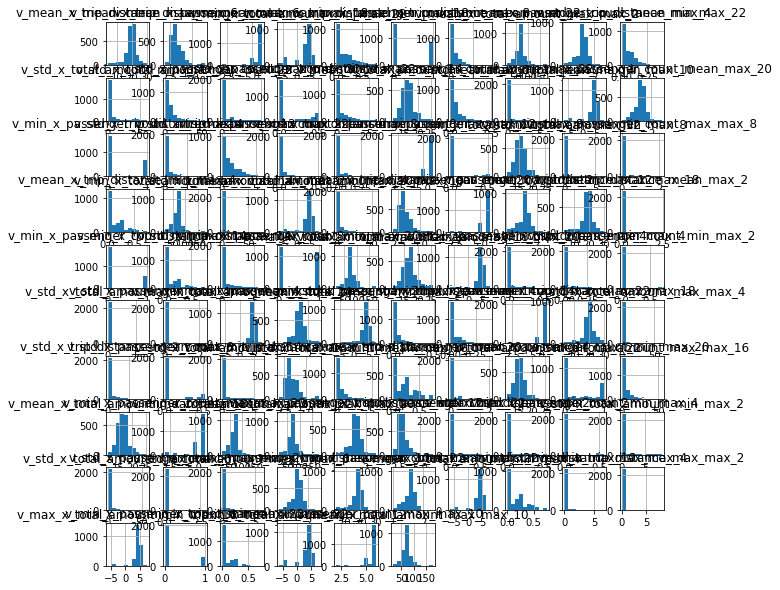

In [47]:
Xi[best].hist(figsize=(10,10))

### Datos Extremos II

#### Método de percentil $P_1,P_{99}$

In [48]:
l_ext = Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()
l_ext

[['v_mean_x_trip_distance_max_max_6', 4.43825, 28.29386666666657],
 ['v_mean_x_trip_distance_mean_max_6', 2.012864761904762, 6.284736842105263],
 ['v_mean_x_passenger_count_max_max_18', 2.3333333333333335, 6.0],
 ['v_min_x_total_amount_min_max_22', -6.3, 5.8],
 ['v_mean_x_trip_distance_min_max_18', 0.0, 0.6555777777777771],
 ['v_max_x_passenger_count_min_max_8', 0.0, 1.0],
 ['v_std_x_trip_distance_mean_max_22', 0.0, 1.0601614115803735],
 ['v_mean_x_total_amount_max_max_2', 18.3504, 176.16],
 ['v_mean_x_passenger_count_mean_max_4',
  1.170731707317073,
  2.1140350877192984],
 ['v_std_x_trip_distance_min_max_22', 0.0, 0.27363071743583356],
 ['v_std_x_total_amount_min_max_20', 0.0, 4.965735224092146],
 ['v_std_x_total_amount_max_max_22', 0.0, 38.6138547421534],
 ['v_std_x_passenger_count_max_max_20', 0.0, 1.6415653633362466],
 ['v_std_x_passenger_count_min_max_22', 0.0, 0.511766315719159],
 ['v_std_x_trip_distance_max_max_14', 0.0, 4.548124216634432],
 ['v_mean_x_total_amount_mean_max_6',

In [49]:
for v,ci,cs in l_ext:
    Xi[f'ol_{v}'] = ((Xi[v]<ci)|(Xi[v]>cs)).astype(int)
varx = [v for v in Xi.columns if v[:2]=='ol']

In [50]:
Xi['extremo'] = Xi[varx].max(axis=1)

In [51]:
Xi['extremo'].value_counts(True)

0    0.727083
1    0.272917
Name: extremo, dtype: float64

In [52]:
Xe = Xi[best+['extremo']+varx].copy()
Xe[um] = X[um]
Xe = Xe.loc[Xe['extremo']!=1].reset_index(drop=True).drop(varx+['extremo'],axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe09bd2a358>,
      dtype=object)

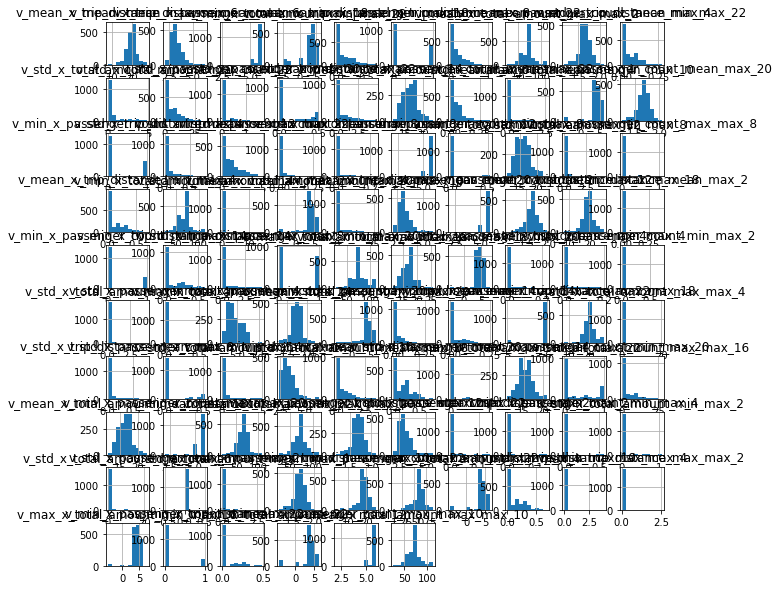

In [53]:
Xe[best].hist(figsize=(10,10))

In [54]:
ye = y.merge(Xe[um],on=um,how='inner')

In [108]:
ye

,hour,ancla,target_1h
0,0,3548,29
1,0,3643,93
2,0,3576,61
3,0,3555,54
4,0,3632,93
...,...,...,...
1740,23,3615,114
1741,23,3616,114
1742,23,3617,114
1743,23,3643,70


### Poder predictivo

In [55]:
sk = SelectKBest(f_regression,k=10)
sk.fit(Xe[best],ye['target_1h'])

SelectKBest(k=10, score_func=<function f_regression at 0x7fe0a9308840>)

In [56]:
best = [x for x,y in zip(best,sk.get_support()) if y]

In [57]:
tgt = 'target_1h'

## Transformación de espacios

### Espacio escala estándar $\vec{y}_s,\mathcal{X}_s,\mu=0,\sigma^2=1$ 

In [58]:
sc,scy = StandardScaler(),MinMaxScaler()

In [59]:
sc.fit(Xe[best])
scy.fit(ye[[tgt]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [60]:
Xs = pd.DataFrame(sc.transform(Xe[best]),columns=best)
ys = pd.DataFrame(scy.transform(ye[[tgt]]),columns=[tgt])

In [61]:
Xs.describe()

,v_mean_x_passenger_count_max_max_18,v_mean_x_trip_distance_max_max_18,v_max_x_total_amount_max_max_18,v_max_x_trip_distance_max_max_18,v_max_x_trip_distance_min_max_20,v_min_x_passenger_count_max_max_20,v_min_x_total_amount_max_max_22,v_mean_x_total_amount_max_max_20,v_min_x_trip_distance_max_max_22,v_min_x_passenger_count_mean_max_22
count,1.745000e+03,1.745000e+03,1.745000e+03,1.745000e+03,1.745000e+03,1.745000e+03,1.745000e+03,1.745000e+03,1.745000e+03,1.745000e+03
mean,7.175222e-15,3.333214e-16,-1.456969e-15,-2.965791e-16,1.034448e-15,-5.601123e-15,-3.181155e-17,5.420688e-17,-1.377440e-16,-9.336053e-16
std,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00
min,-9.582262e+00,-4.247667e+00,-3.310898e+00,-4.255628e+00,-1.007488e+00,-7.368125e+00,-3.936700e+00,-3.510769e+00,-4.972681e+00,-4.350131e+00
25%,4.462922e-01,-4.550834e-01,-4.104440e-01,-5.535806e-01,-1.007488e+00,4.705448e-01,-5.456586e-01,-4.803965e-01,-3.620251e-01,-3.574043e-01
50%,4.462922e-01,6.166486e-02,-2.191038e-01,6.126993e-02,-4.104883e-02,4.705448e-01,2.594320e-01,-7.336836e-02,7.148410e-02,1.304331e-01
75%,4.462922e-01,5.222869e-01,4.802778e-01,4.334163e-01,6.411437e-01,4.705448e-01,5.412137e-01,4.300348e-01,6.528569e-01,5.071177e-01
max,4.462922e-01,2.803334e+00,2.384443e+00,2.485075e+00,3.313064e+00,4.705448e-01,3.425048e+00,3.149832e+00,2.296159e+00,2.411468e+00


In [62]:
ys.describe()

,target_1h
count,1745.000000
mean,0.539557
std,0.269367
min,0.000000
25%,0.305556
50%,0.604167
75%,0.763889
max,1.000000


### Espacio de componentes principales $\mathcal{X}_p$

In [88]:
Xs[best].corr()

,v_mean_x_passenger_count_max_max_18,v_mean_x_trip_distance_max_max_18,v_max_x_total_amount_max_max_18,v_max_x_trip_distance_max_max_18,v_max_x_trip_distance_min_max_20,v_min_x_passenger_count_max_max_20,v_min_x_total_amount_max_max_22,v_mean_x_total_amount_max_max_20,v_min_x_trip_distance_max_max_22,v_min_x_passenger_count_mean_max_22
v_mean_x_passenger_count_max_max_18,1.000000,0.299757,0.149325,0.310388,-0.335624,0.813809,0.176028,0.171208,0.225094,0.391823
v_mean_x_trip_distance_max_max_18,0.299757,1.000000,0.466228,0.896837,-0.165392,0.244496,0.520553,0.562971,0.819213,0.119296
v_max_x_total_amount_max_max_18,0.149325,0.466228,1.000000,0.467526,-0.159859,0.107551,0.563764,0.883937,0.468883,0.087939
v_max_x_trip_distance_max_max_18,0.310388,0.896837,0.467526,1.000000,-0.118224,0.262523,0.437750,0.475457,0.687357,0.119304
v_max_x_trip_distance_min_max_20,-0.335624,-0.165392,-0.159859,-0.118224,1.000000,-0.282470,-0.336819,-0.245614,-0.214632,-0.331114
v_min_x_passenger_count_max_max_20,0.813809,0.244496,0.107551,0.262523,-0.282470,1.000000,0.152420,0.123424,0.217304,0.475902
v_min_x_total_amount_max_max_22,0.176028,0.520553,0.563764,0.437750,-0.336819,0.152420,1.000000,0.764432,0.660893,0.113063
v_mean_x_total_amount_max_max_20,0.171208,0.562971,0.883937,0.475457,-0.245614,0.123424,0.764432,1.000000,0.564597,0.095273
v_min_x_trip_distance_max_max_22,0.225094,0.819213,0.468883,0.687357,-0.214632,0.217304,0.660893,0.564597,1.000000,0.136256
v_min_x_passenger_count_mean_max_22,0.391823,0.119296,0.087939,0.119304,-0.331114,0.475902,0.113063,0.095273,0.136256,1.000000


In [89]:
pca = PCA(n_components=10)

In [90]:
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [91]:
Xp = pd.DataFrame(pca.transform(Xs))

In [92]:
Xp.corr().round(2)

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
2,-0.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
3,-0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0
5,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0
6,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0
7,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0
8,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0
9,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [93]:
pca.explained_variance_ratio_.cumsum()

array([0.4472491 , 0.64851741, 0.76053534, 0.83747767, 0.90117269,
       0.94654568, 0.96856042, 0.98572507, 0.99632129, 1.        ])

In [94]:
mm = MinMaxScaler()
mm.fit(Xp)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [95]:
Xp = pd.DataFrame(mm.transform(Xp))

In [96]:
Xp.describe()

,0,1,2,3,4,5,6,7,8,9
count,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000
mean,0.340625,0.248980,0.403790,0.323501,0.432866,0.339332,0.366490,0.319259,0.464169,0.495936
std,0.144016,0.110723,0.173344,0.118725,0.131425,0.153918,0.155495,0.059425,0.102842,0.118588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.255966,0.183056,0.277028,0.249955,0.358091,0.233291,0.256663,0.291045,0.427722,0.449519
50%,0.315422,0.221888,0.393644,0.320617,0.442705,0.321025,0.352731,0.319465,0.450159,0.496658
75%,0.418288,0.295555,0.520484,0.402057,0.517856,0.431680,0.459902,0.334465,0.507822,0.538258
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Pipeline (opcional)

In [97]:
pi = make_pipeline(SimpleImputer(strategy='median'),
                   StandardScaler(),
                   PCA(n_components=10),
                   MinMaxScaler())

In [98]:
pi.fit(X[best])

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('minmaxscaler',
                 MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [99]:
Xpp = pd.DataFrame(pi.transform(X[best]))

## Entrenamiento

### Partición

In [100]:
Xt,Xv,yt,yv = train_test_split(Xp,ys)
Xt.shape,yt.shape,Xv.shape,yv.shape

((1308, 10), (1308, 1), (437, 10), (437, 1))

### Red neuronal

In [101]:
MAX_NEURONAS = len(best)*2
hyper_param = dict(hidden_layer_sizes=[(a,b,c,) for a in range(1,MAX_NEURONAS+1) for b in range(1,MAX_NEURONAS+1) for c in range(1,MAX_NEURONAS+1) ],
                   activation = ['identity', 'logistic', 'tanh', 'relu'],
                   alpha = np.arange(0.01,1,0.01),
                   learning_rate = ['constant', 'invscaling', 'adaptive'],
                  )

ann = MLPRegressor()

grid = RandomizedSearchCV(estimator=ann,
                          n_iter=100,
                    param_distributions=hyper_param,
                    error_score='mean_absolute_error',
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

display(grid.best_score_)

ann = grid.best_estimator_
ann

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


0.4626741458278701

MLPRegressor(activation='relu', alpha=0.22, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(12, 6, 19), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

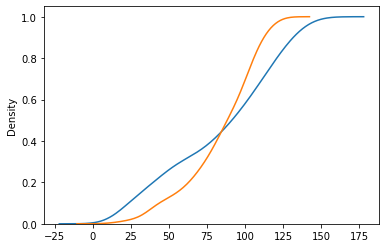

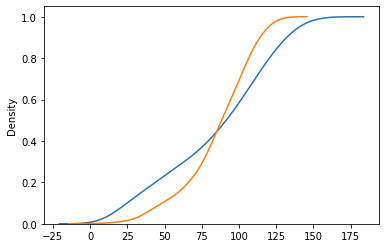

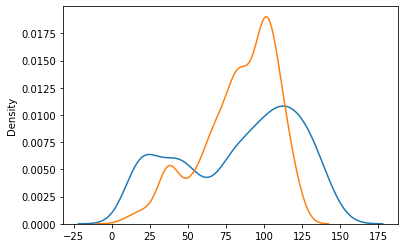

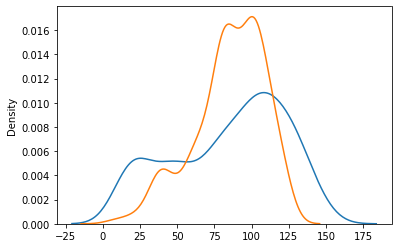

In [102]:
plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(ann.predict(Xt))),hist=False,kde_kws={'cumulative':True})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(ann.predict(Xv))),hist=False,kde_kws={'cumulative':True})

plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(ann.predict(Xt))),hist=False,kde_kws={'cumulative':False})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(ann.predict(Xv))),hist=False,kde_kws={'cumulative':False})

In [103]:
jiji = scy.inverse_transform(pd.DataFrame(ann.predict(Xp)))

jiji

array([[48.64156362],
       [62.25226837],
       [62.25226837],
       ...,
       [85.08162399],
       [84.66832687],
       [84.99076807]])

### Random Forest

In [104]:
hyper_param = dict(n_estimators = range(10,200),
                   criterion = ["mse", "mae"],
                   max_depth = range(1,20))

rf = RandomForestRegressor()

grid = RandomizedSearchCV(estimator=rf,
                          n_iter=1,
                    param_distributions=hyper_param,
                    error_score='mean_absolute_error',
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

display(grid.best_score_)

rf = grid.best_estimator_
rf

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s finished


0.7495864401780098

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=18, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=142, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

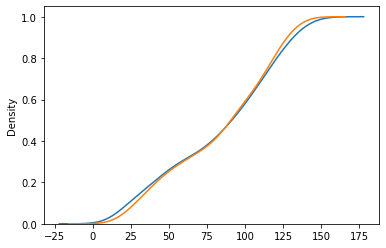

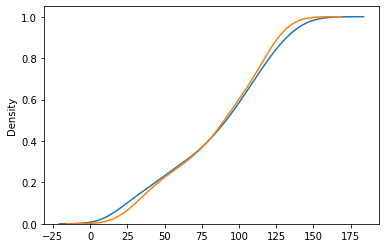

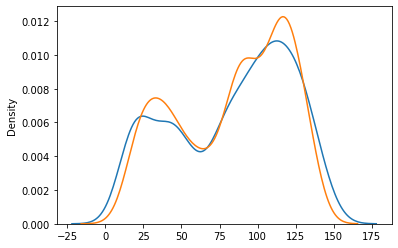

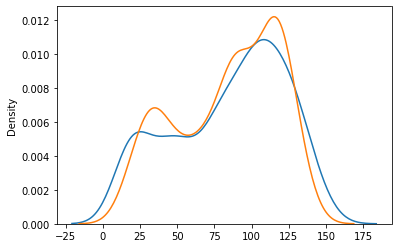

In [105]:
plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(rf.predict(Xt))),hist=False,kde_kws={'cumulative':True})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(rf.predict(Xv))),hist=False,kde_kws={'cumulative':True})

plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(rf.predict(Xt))),hist=False,kde_kws={'cumulative':False})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(rf.predict(Xv))),hist=False,kde_kws={'cumulative':False})

In [106]:
jiji = scy.inverse_transform(pd.DataFrame(ann.predict(xp)))
jiji

NameError: ignored

### XGBoost

In [ ]:
hyper_param = dict(n_estimators = range(10,200),
                   criterion = ["gini", "entropy"],
                   learning_rate = np.arange(0.001,0.01,0.001),
                   gamma = np.arange(0.001,0.01,0.001),
                   max_depth = range(1,20))

xgb = XGBRegressor()

grid = RandomizedSearchCV(estimator=xgb,
                          n_iter=1,
                    param_distributions=hyper_param,
                    error_score='mean_absolute_error',
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

display(grid.best_score_)

xgb = grid.best_estimator_
xgb

In [ ]:
plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(xgb.predict(Xt))),hist=False,kde_kws={'cumulative':True})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(xgb.predict(Xv))),hist=False,kde_kws={'cumulative':True})

plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(xgb.predict(Xt))),hist=False,kde_kws={'cumulative':False})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(xgb.predict(Xv))),hist=False,kde_kws={'cumulative':False})

### Regresión Lineal

In [ ]:
lr = LinearRegression()
lr.fit(Xt,yt)

In [ ]:
lr.coef_,lr.intercept_

In [ ]:
plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(lr.predict(Xt))),hist=False,kde_kws={'cumulative':True})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':True})
sns.distplot(scy.inverse_transform(pd.DataFrame(lr.predict(Xv))),hist=False,kde_kws={'cumulative':True})

plt.figure()
sns.distplot(scy.inverse_transform(yt),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(lr.predict(Xt))),hist=False,kde_kws={'cumulative':False})
plt.figure()
sns.distplot(scy.inverse_transform(yv),hist=False,kde_kws={'cumulative':False})
sns.distplot(scy.inverse_transform(pd.DataFrame(lr.predict(Xv))),hist=False,kde_kws={'cumulative':False})